# Understanding the knickpoints in the Rapel landscape and the erosion rate distributions therein

In [22]:
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from TopoAnalysis import dem as d
from scipy.stats import linregress
from scipy.signal import savgol_filter
from rasterio.mask import mask as rasterio_mask
from rasterio.features import geometry_mask as rasterio_geom_mask

In [23]:
# Caluclate the chi elevation and plot to find the elvation 
# d.Chi(flow_direction = fd, area = area, theta = <theta>, Ao = <Ao> (not particularly sensitive to that value), outlets = list of (x,y) coordinates of outlets)
# chi vs elevation plot

outlets = [
    (246249.2076, 6240448.447),
    (250212.9354, 6237948.848),
    (250603.5211, 6228481.157),
    (262281.9748, 6217862.614),
    (264603.93, 6224733.92)
]

In [24]:
area = d.Area.load('/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_area_utm30m')
fd = d.FlowDirectionD8.load('/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_fd_utm30m')
elevation = d.Elevation.load('/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_SRTMGL130m_dem_utm.tif')

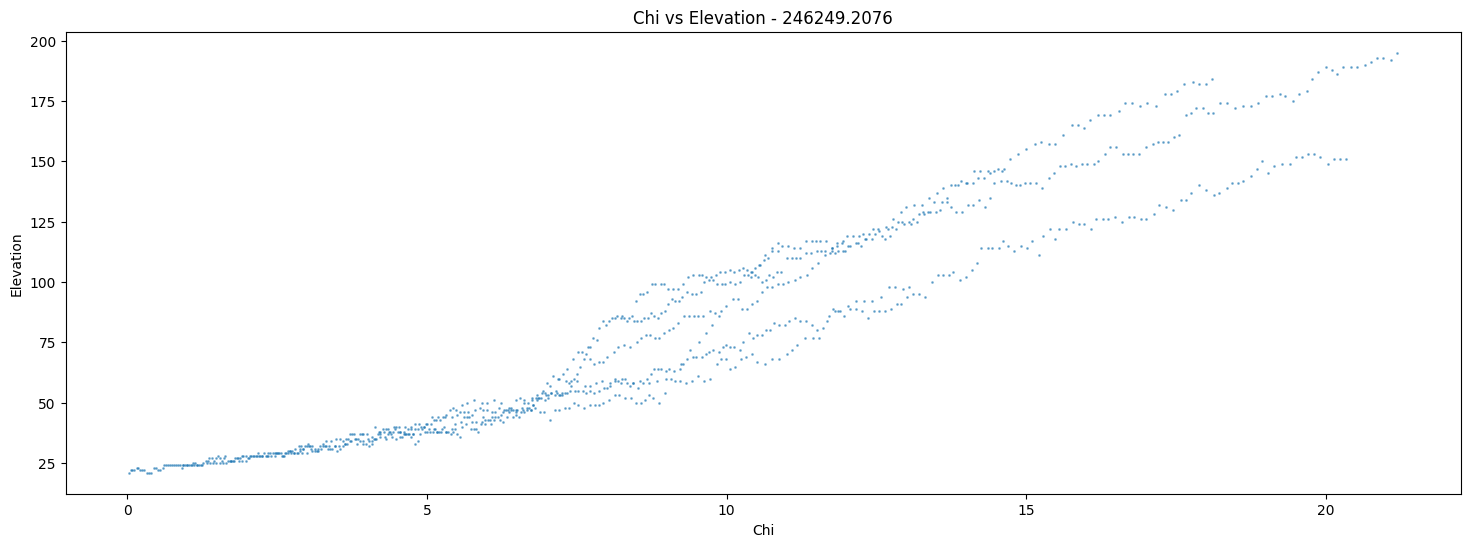

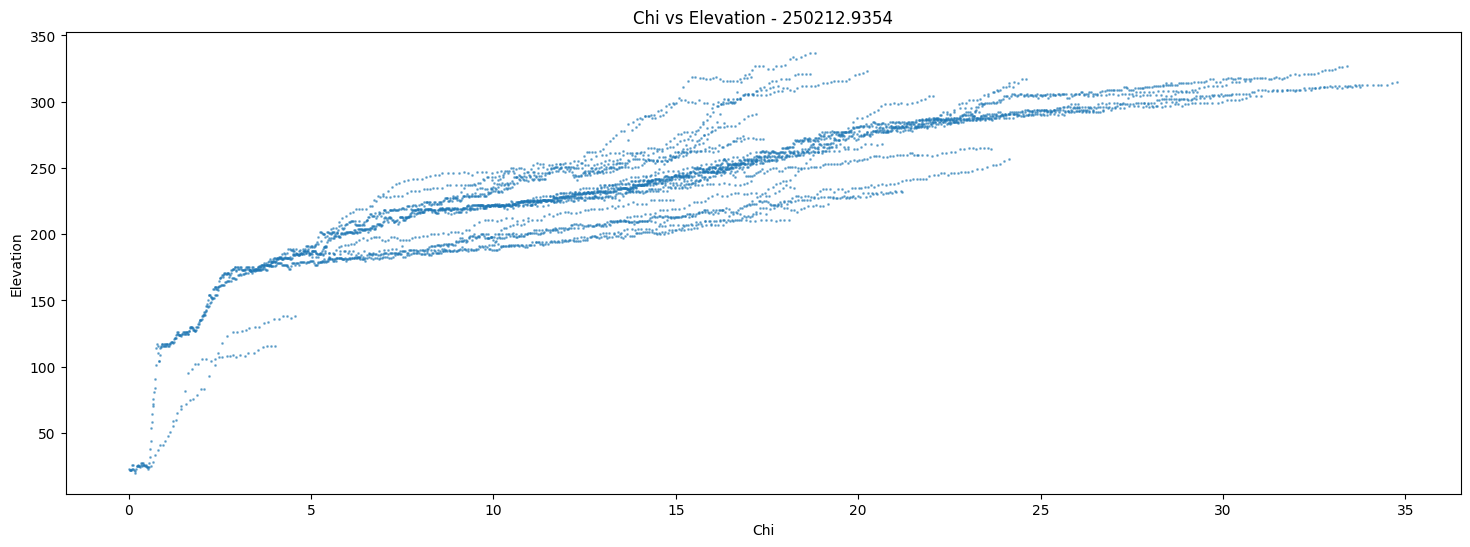

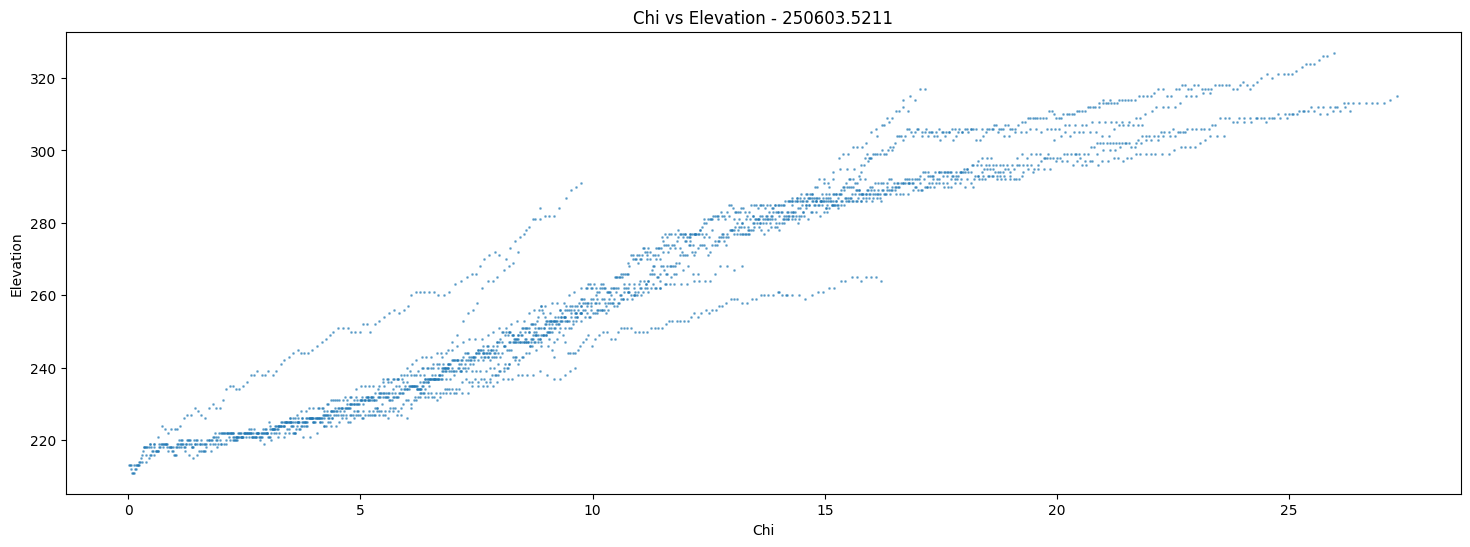

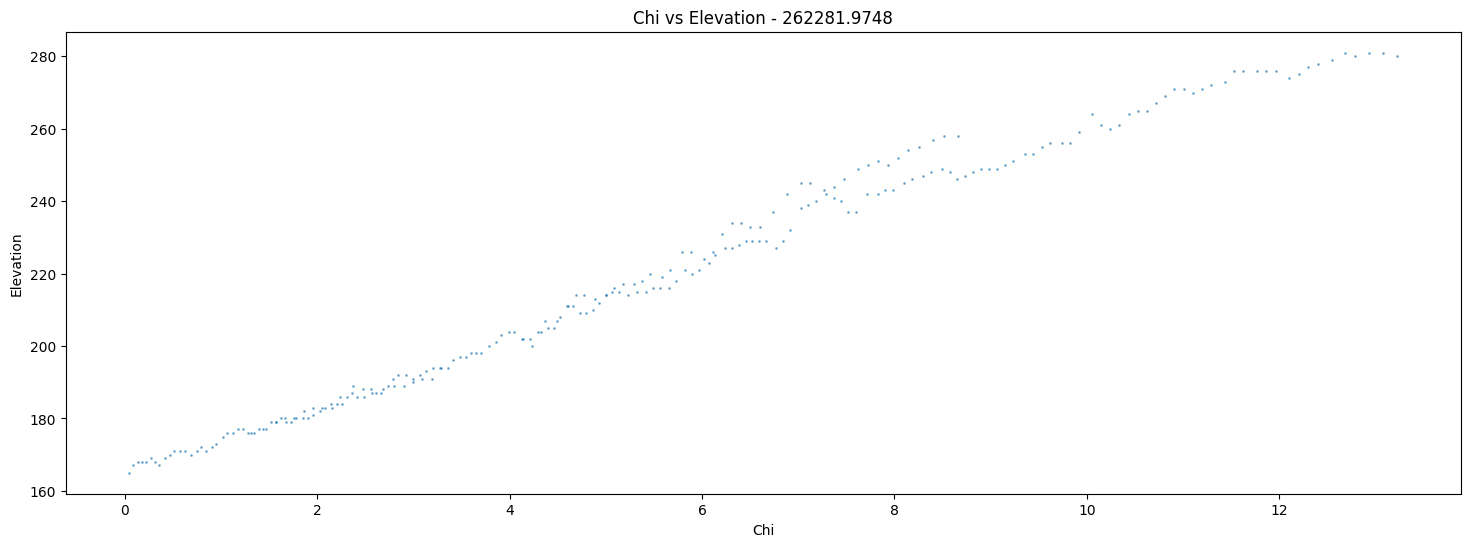

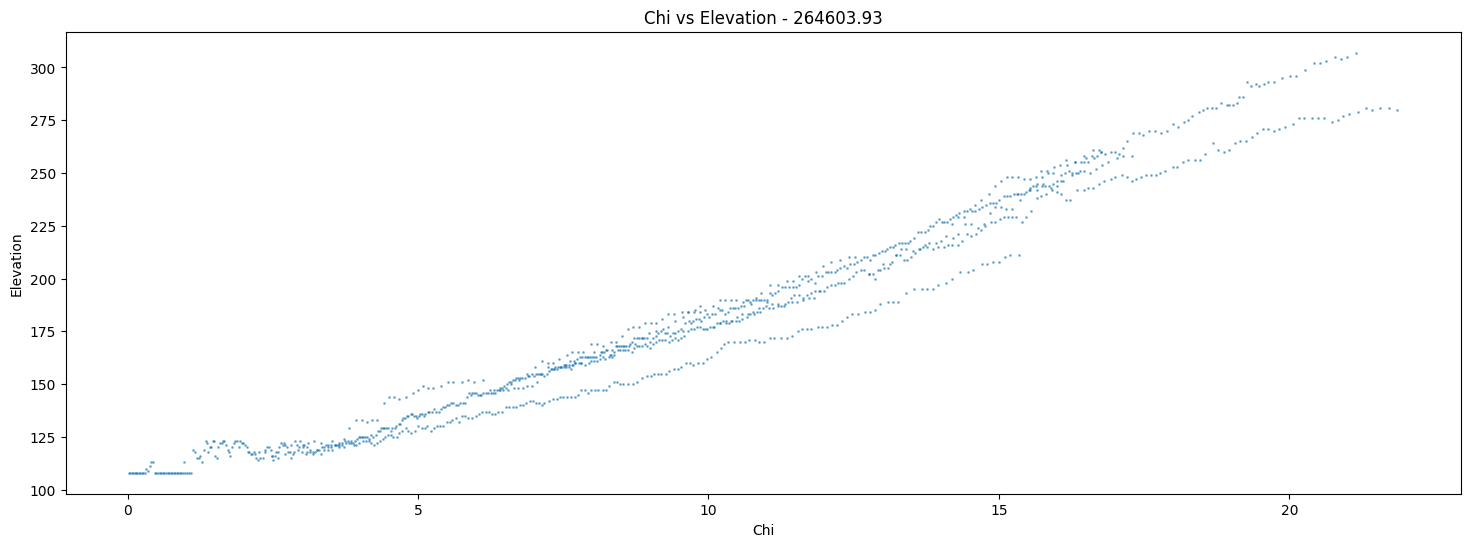

In [25]:
for outlet in outlets:
    chi_single = d.Chi(flow_direction = fd, area = area, theta = 0.4, Ao = 1, outlets = [outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask_out = area_data >= 1e6  # 1 km^2 in m^2
    
    plt.figure(figsize=(18, 6))
    plt.scatter(chi_data[mask_out], elev_data[mask_out], s=1, alpha=0.5)
    plt.xlabel('Chi')
    plt.ylabel('Elevation')
    plt.title(f'Chi vs Elevation - {outlet[0]}')
    plt.show()


RP-S2:
  Chi: 8.75, Elevation: 99


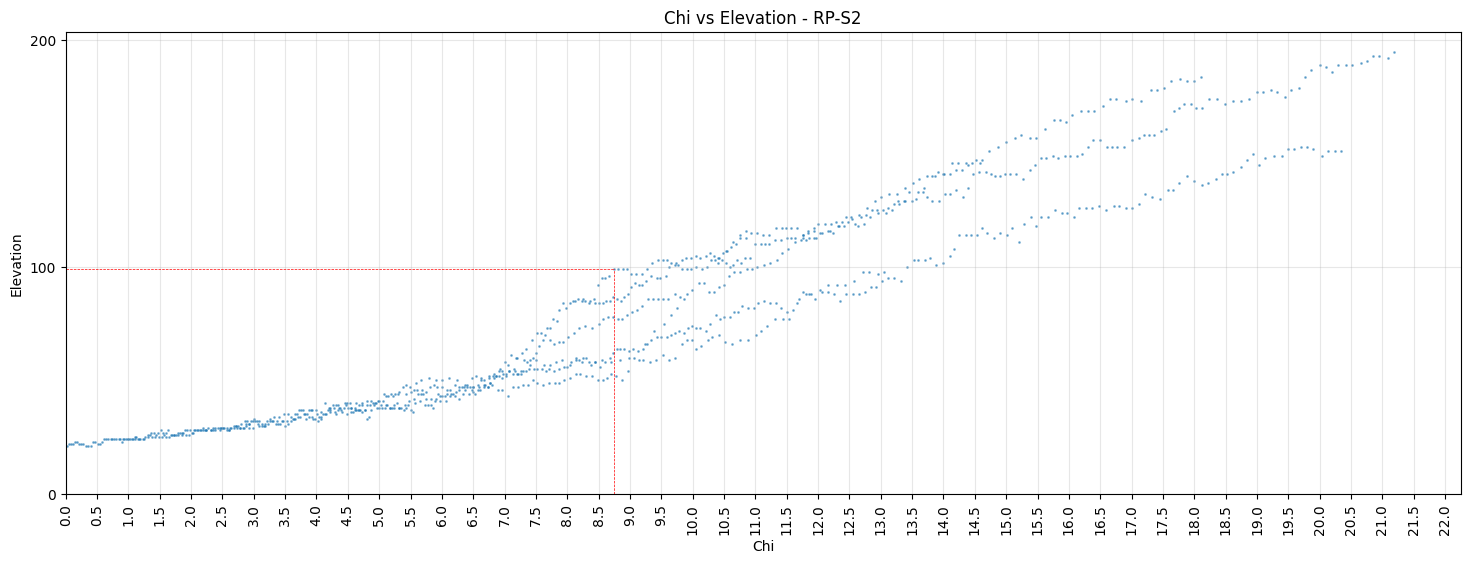


RP-S3:
  Chi: 0.78, Elevation: 117
  Chi: 2.90, Elevation: 175
  Chi: 8.50, Elevation: 245


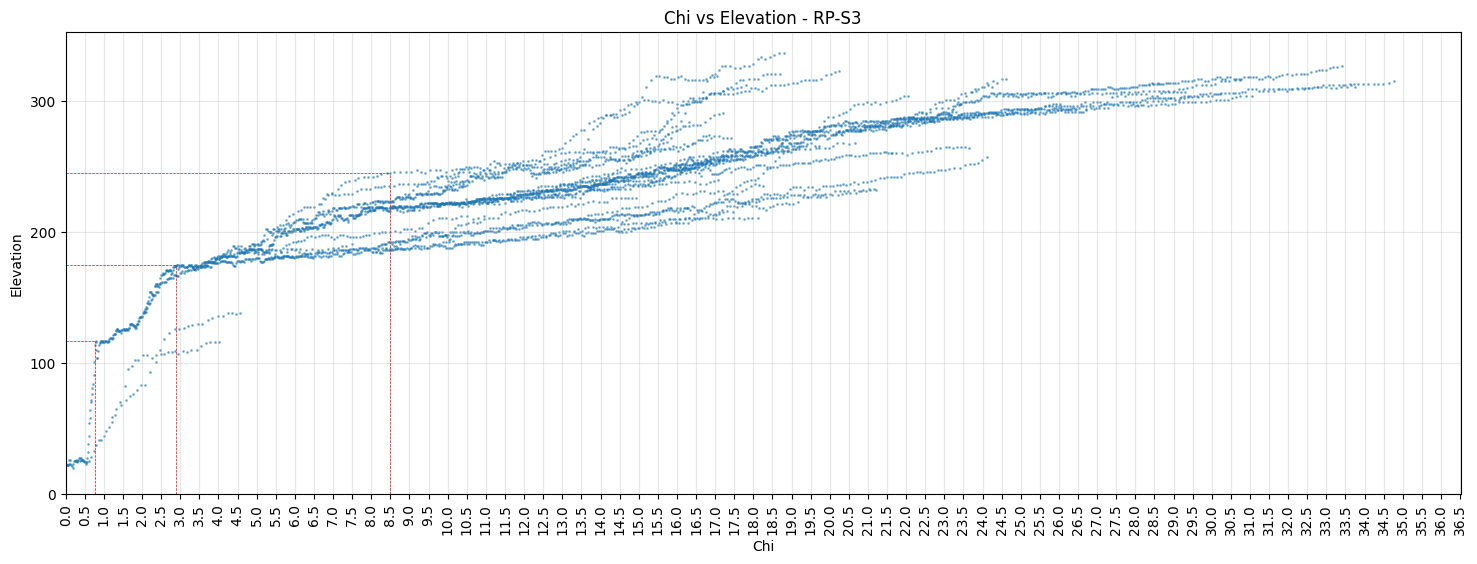

In [26]:
outlet_names = ['RP-S2', 'RP-S3']
outlets = [(246249.2076, 6240448.447),
           (250212.9354, 6237948.848)  # Use only these outlets
          ]
           
for i, outlet in enumerate(outlets):
    chi_single = d.Chi(flow_direction = fd, area = area, theta = 0.4, Ao = 1, outlets = [outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask_out = area_data >= 1e6
    chi_masked = chi_data[mask_out]
    elev_masked = elev_data[mask_out]
    
    plt.figure(figsize=(18, 6))
    plt.scatter(chi_masked, elev_masked, s=1, alpha=0.5)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.5))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(100))
    
    plt.grid(True, alpha=0.3, which='major')
    plt.gca().tick_params(axis='x', rotation=90)
    
    # Knickpoint dictionary
    knickpoints_dict = {
        'RP-S2': [8.75],
        'RP-S3': [0.78, 2.9, 8.5],
    }
    
    outlet_name = outlet_names[i]
    knickpoints = knickpoints_dict.get(outlet_name, [])
    
    print(f"\n{outlet_name}:")
    for chi_val in knickpoints:
        idx = np.argmin(np.abs(chi_masked - chi_val))
        elev_val = elev_masked[idx]
        
        print(f"  Chi: {chi_val:.2f}, Elevation: {elev_val:.0f}")
        
        # Lines only to intersection point
        plt.plot([chi_val, chi_val], [0, elev_val], 'r--', linewidth=0.5)
        plt.plot([0, chi_val], [elev_val, elev_val], 'r--', linewidth=0.5)
    
    plt.xlabel('Chi')
    plt.ylabel('Elevation')
    plt.title(f'Chi vs Elevation - {outlet_name}')
    plt.show()

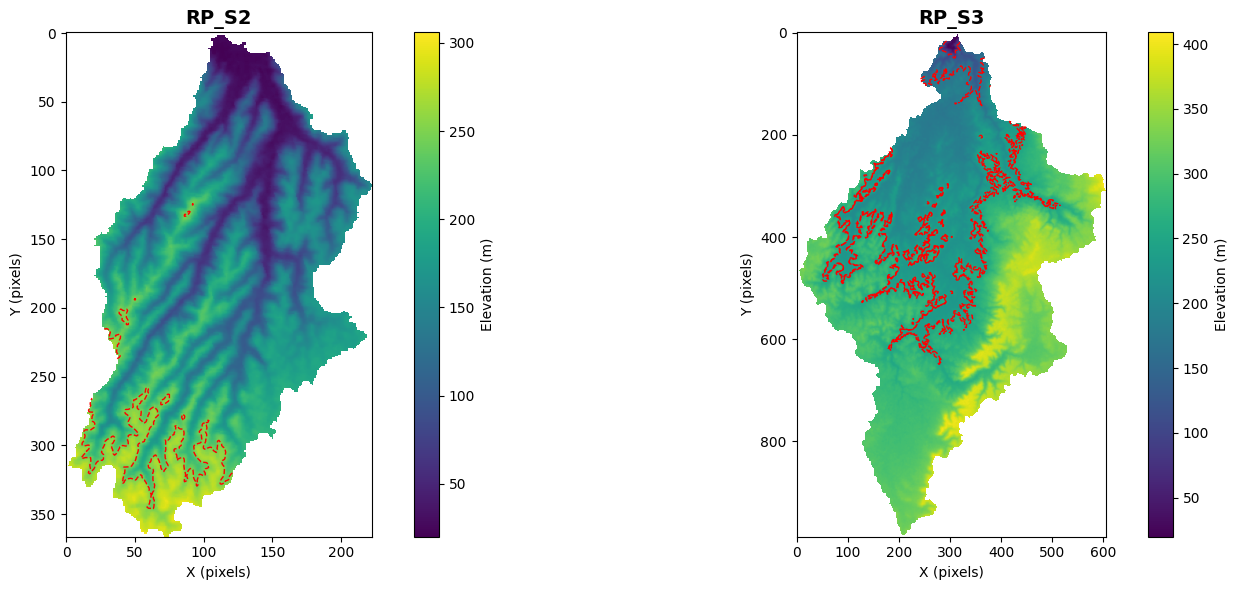

In [27]:
import rasterio
from rasterio.mask import mask as rasterio_mask
from rasterio.features import geometry_mask
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

dem_file = '/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_SRTMGL130m_dem_utm.tif'
watersheds = [
    ('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S2_mask/RP_S2_mask.shp', 'RP_S2', 8.75),
    ('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3_mask/RP_S3_mask.shp', 'RP_S3', [0.75, 2.75, 8.5, 15.5]),
]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (polygon_file, watershed_name, knickpoints) in enumerate(watersheds):
    ax = axes[idx]
    
    # Load polygon
    polygon = gpd.read_file(polygon_file)
    shapes = [geom for geom in polygon.geometry]
    
    # Load and mask DEM - use rasterio_mask instead of mask
    with rasterio.open(dem_file) as src:
        dem_data, dem_transform = rasterio_mask(src, shapes, crop=True)
        dem_data = dem_data[0].astype(float)
    
    # Set pixels outside polygon to NaN
    geom_mask_array = geometry_mask(shapes, out_shape=dem_data.shape, transform=dem_transform, invert=True)
    dem_data[~geom_mask_array] = np.nan
    
    # Convert knickpoints to list if single value
    if not isinstance(knickpoints, list):
        knickpoints = [knickpoints]
    
    # Plot DEM
    im = ax.imshow(dem_data, cmap='viridis')
    plt.colorbar(im, ax=ax, label='Elevation (m)')
    
    # Draw contour lines for each knickpoint elevation
    for knickpoint_chi in knickpoints:
        # Get elevation at this chi value
        idx_chi = np.argmin(np.abs(chi_masked - knickpoint_chi))
        knickpoint_elevation = elev_masked[idx_chi]
        
        # Draw contour line at that elevation
        ax.contour(dem_data, levels=[knickpoint_elevation], colors='red', linewidths=1, linestyles='--')
    
    ax.set_title(f'{watershed_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')

plt.tight_layout()
plt.savefig('/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/BaseLevel/Figures/erosion_analysis_knickpoints.png', dpi=150, bbox_inches='tight')
plt.show()


RP_S3:

Knickpoint elevation: 117m
  Area above 117m: 208.87 km²
  Area below 117m: 0.96 km²
  Total area: 209.83 km²
  Proportion above: 99.5%
  Proportion below: 0.5%
  Erosion rate (upper): 30 m/Myr
  Erosion rate (lower calculated): 34.00 m/Myr
  Weighted average erosion rate: 30.02 m/Myr

Knickpoint elevation: 175m
  Area above 175m: 203.42 km²
  Area below 175m: 6.41 km²
  Total area: 209.83 km²
  Proportion above: 96.9%
  Proportion below: 3.1%
  Erosion rate (upper): 30 m/Myr
  Erosion rate (lower calculated): 34.00 m/Myr
  Weighted average erosion rate: 30.12 m/Myr


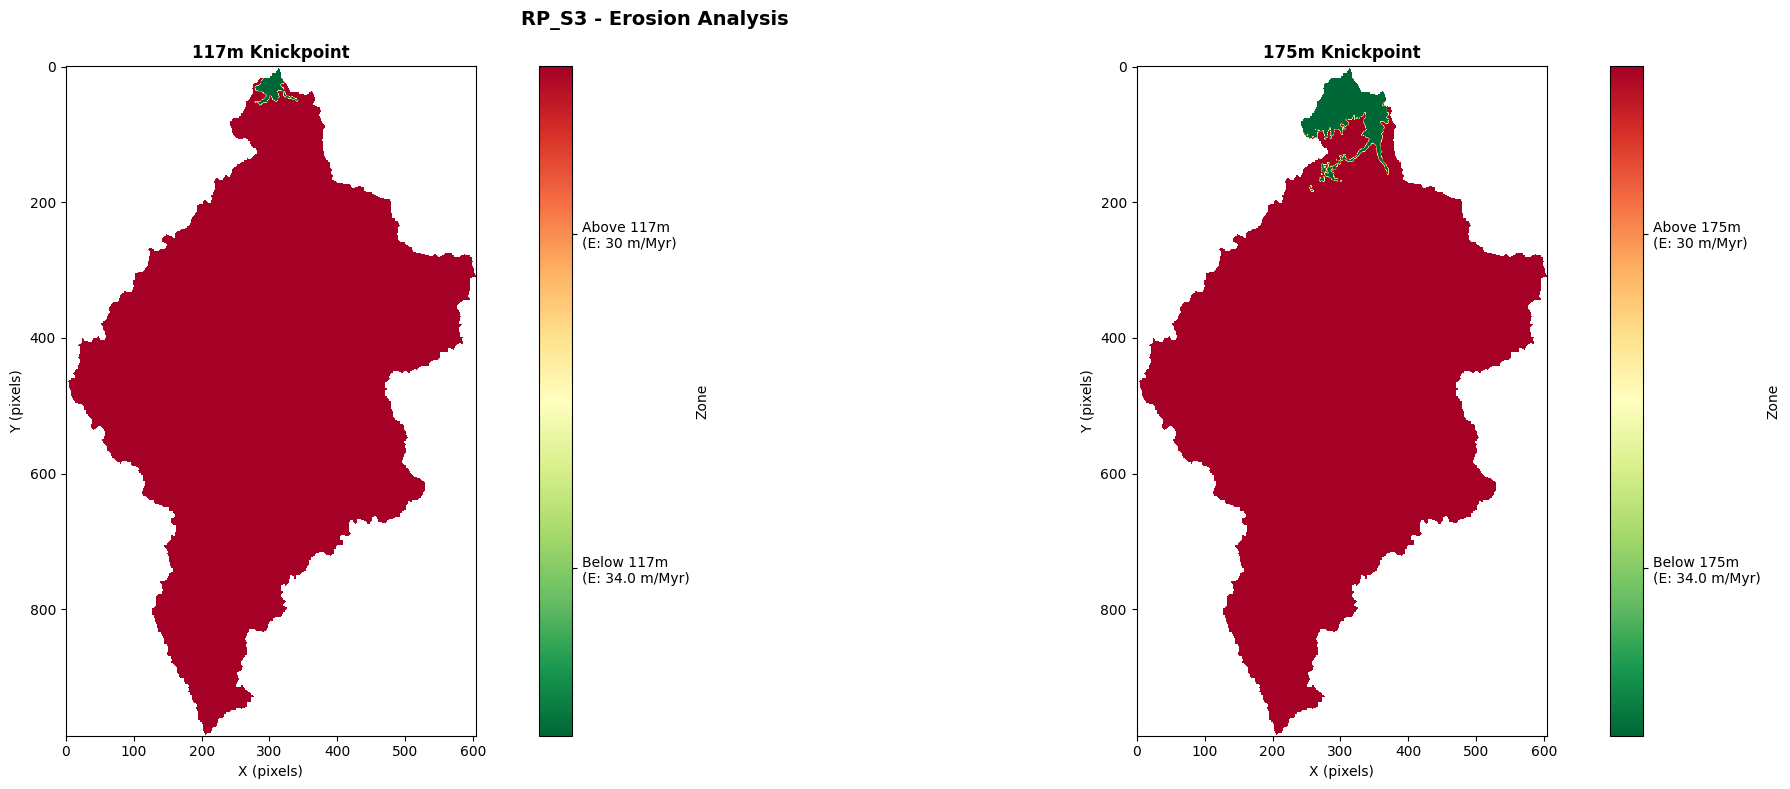

In [29]:
def analyze_erosion(dem_file, polygon_file, watershed_name, erosion_above=30, erosion_below=34, knickpoint_elevations=[117, 175]):
    """
    Analyze area-weighted erosion rates for a watershed with multiple knickpoints.
    """
    
    # Load polygon
    polygon = gpd.read_file(polygon_file)
    shapes = [geom for geom in polygon.geometry]
    
    # Load and mask DEM
    with rasterio.open(dem_file) as src:
        dem_data, dem_transform = rasterio_mask(src, shapes, crop=True)
        dem_data = dem_data[0].astype(float)
    
    # Set pixels outside polygon to NaN
    geom_mask = rasterio_geom_mask(shapes, out_shape=dem_data.shape, transform=dem_transform, invert=True)
    dem_data[~geom_mask] = np.nan
    
    # Get cell size
    cell_size = dem_transform[0]
    cell_area = cell_size ** 2
    
    # Analyze for each knickpoint elevation
    print(f"\n{watershed_name}:")
    print("="*60)
    
    # Create one figure with subplots for each knickpoint
    fig, axes = plt.subplots(1, len(knickpoint_elevations), figsize=(12 * len(knickpoint_elevations), 8))
    if len(knickpoint_elevations) == 1:
        axes = [axes]
    
    for idx, knickpoint_elevation in enumerate(knickpoint_elevations):
        ax = axes[idx]
        # Create masks for above and below knickpoint
        valid_mask = ~np.isnan(dem_data)
        above_mask = (dem_data > knickpoint_elevation) & valid_mask
        below_mask = (dem_data <= knickpoint_elevation) & valid_mask
        
        # Calculate areas
        area_above = np.sum(above_mask) * cell_area
        area_below = np.sum(below_mask) * cell_area
        total_area = area_above + area_below
        
        # Calculate weighted average erosion rate
        weighted_erosion = (erosion_above * area_above + erosion_below * area_below) / total_area
        
        # Calculate lower erosion rate using: E_lower = (E_total*A_total - E_upper*A_upper) / A_lower
        erosion_lower_calc = (weighted_erosion * total_area - erosion_above * area_above) / area_below
        
        # Create visualization
        colored_dem = np.full_like(dem_data, np.nan, dtype=float)
        colored_dem[above_mask] = 1
        colored_dem[below_mask] = 0
        
        im = ax.imshow(colored_dem, cmap='RdYlGn_r', vmin=0, vmax=1)
        cbar = plt.colorbar(im, ax=ax, label='Zone')
        cbar.set_ticks([0.25, 0.75])
        cbar.set_ticklabels([f'Below {knickpoint_elevation}m\n(E: {erosion_lower_calc:.1f} m/Myr)', 
                              f'Above {knickpoint_elevation}m\n(E: {erosion_above} m/Myr)'])
        
        ax.set_title(f'{knickpoint_elevation}m Knickpoint', fontsize=12, fontweight='bold')
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Y (pixels)')
        
        # Print results
        print(f"\nKnickpoint elevation: {knickpoint_elevation}m")
        print(f"  Area above {knickpoint_elevation}m: {area_above/1e6:,.2f} km²")
        print(f"  Area below {knickpoint_elevation}m: {area_below/1e6:,.2f} km²")
        print(f"  Total area: {total_area/1e6:,.2f} km²")
        print(f"  Proportion above: {area_above/total_area*100:.1f}%")
        print(f"  Proportion below: {area_below/total_area*100:.1f}%")
        print(f"  Erosion rate (upper): {erosion_above} m/Myr")
        print(f"  Erosion rate (lower calculated): {erosion_lower_calc:.2f} m/Myr")
        print(f"  Weighted average erosion rate: {weighted_erosion:.2f} m/Myr")
    
    plt.suptitle(f'{watershed_name} - Erosion Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'/Users/Glong1/Desktop/erosion_analysis_{watershed_name}.png', dpi=150, bbox_inches='tight')
    plt.show()


# Use the function on all watersheds
dem_file = '/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_SRTMGL130m_dem_utm.tif'
watersheds = [
    ('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3_mask/RP_S3_mask.shp', 'RP_S3'),    
]

for polygon_file, name in watersheds:
    analyze_erosion(dem_file, polygon_file, name, erosion_above=30, erosion_below=34, knickpoint_elevations=[117, 175])


RP_S3:

Knickpoint elevation: 117m
  Area above 117m: 208.87 km²
  Area below 117m: 0.96 km²
  Total area: 209.83 km²
  Proportion above: 99.5%
  Proportion below: 0.5%
  Erosion rate (upper): 30 m/Myr
  Erosion rate (lower calculated): 901.12 m/Myr
  Weighted average erosion rate: 34.00 m/Myr

Knickpoint elevation: 175m
  Area above 175m: 203.42 km²
  Area below 175m: 6.41 km²
  Total area: 209.83 km²
  Proportion above: 96.9%
  Proportion below: 3.1%
  Erosion rate (upper): 30 m/Myr
  Erosion rate (lower calculated): 160.89 m/Myr
  Weighted average erosion rate: 34.00 m/Myr


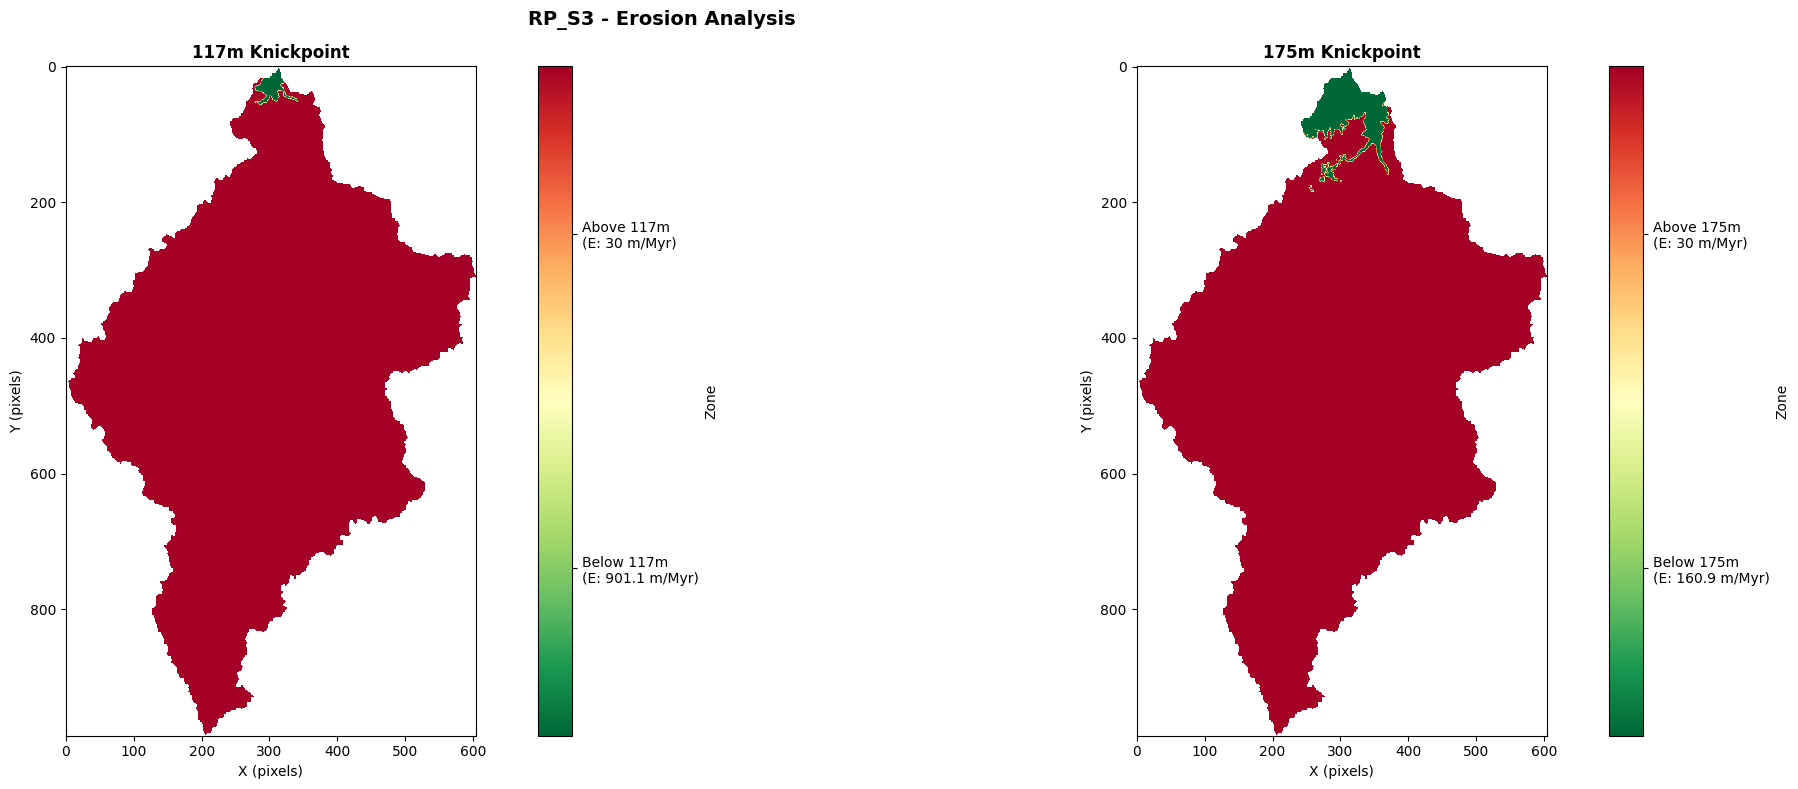

In [30]:
def analyze_erosion(dem_file, polygon_file, watershed_name, erosion_above=30, erosion_below=34, knickpoint_elevations=[117, 175]):
    """
    Analyze area-weighted erosion rates for a watershed with multiple knickpoints.
    
    Parameters:
    - dem_file: path to DEM raster file
    - polygon_file: path to watershed polygon shapefile
    - watershed_name: name for the watershed
    - erosion_above: erosion rate above knickpoint (m/Myr) - default 30
    - erosion_below: erosion rate below knickpoint (m/Myr) - default 34
    - knickpoint_elevations: list of elevation thresholds to analyze
    """
    
    # Load polygon
    polygon = gpd.read_file(polygon_file)
    shapes = [geom for geom in polygon.geometry]
    
    # Load and mask DEM
    with rasterio.open(dem_file) as src:
        dem_data, dem_transform = mask(src, shapes, crop=True)
        dem_data = dem_data[0].astype(float)
    
    # Set pixels outside polygon to NaN
    geom_mask = geometry_mask(shapes, out_shape=dem_data.shape, transform=dem_transform, invert=True)
    dem_data[~geom_mask] = np.nan
    
    # Get cell size
    cell_size = dem_transform[0]
    cell_area = cell_size ** 2
    
    # Analyze for each knickpoint elevation
    print(f"\n{watershed_name}:")
    print("="*60)
    
    # Create one figure with subplots for each knickpoint
    fig, axes = plt.subplots(1, len(knickpoint_elevations), figsize=(12 * len(knickpoint_elevations), 8))
    if len(knickpoint_elevations) == 1:
        axes = [axes]
    
    for idx, knickpoint_elevation in enumerate(knickpoint_elevations):
        ax = axes[idx]
        # Create masks for above and below knickpoint
        valid_mask = ~np.isnan(dem_data)
        above_mask = (dem_data > knickpoint_elevation) & valid_mask
        below_mask = (dem_data <= knickpoint_elevation) & valid_mask
        
        # Calculate areas
        area_above = np.sum(above_mask) * cell_area
        area_below = np.sum(below_mask) * cell_area
        total_area = area_above + area_below
        
        # Skip if no area below knickpoint
        if area_below == 0:
            print(f"\nKnickpoint elevation: {knickpoint_elevation}m - SKIPPED (no area below knickpoint)")
            continue
        
        # Calculate lower erosion rate using: E_lower = (E_total*A_total - E_upper*A_upper) / A_lower
        # Rearranged from: E_total = (E_upper*A_upper + E_lower*A_lower) / A_total
        # We use erosion_below as E_total (the overall watershed erosion rate)
        erosion_lower_calc = (erosion_below * total_area - erosion_above * area_above) / area_below
        
        # Calculate weighted average for reference
        weighted_erosion = (erosion_above * area_above + erosion_lower_calc * area_below) / total_area
        
        # Create visualization
        colored_dem = np.full_like(dem_data, np.nan, dtype=float)
        colored_dem[above_mask] = 1
        colored_dem[below_mask] = 0
        
        im = ax.imshow(colored_dem, cmap='RdYlGn_r', vmin=0, vmax=1)
        cbar = plt.colorbar(im, ax=ax, label='Zone')
        cbar.set_ticks([0.25, 0.75])
        cbar.set_ticklabels([f'Below {knickpoint_elevation}m\n(E: {erosion_lower_calc:.1f} m/Myr)', 
                              f'Above {knickpoint_elevation}m\n(E: {erosion_above} m/Myr)'])
        
        ax.set_title(f'{knickpoint_elevation}m Knickpoint', fontsize=12, fontweight='bold')
        ax.set_xlabel('X (pixels)')
        ax.set_ylabel('Y (pixels)')
        
        # Print results
        print(f"\nKnickpoint elevation: {knickpoint_elevation}m")
        print(f"  Area above {knickpoint_elevation}m: {area_above/1e6:,.2f} km²")
        print(f"  Area below {knickpoint_elevation}m: {area_below/1e6:,.2f} km²")
        print(f"  Total area: {total_area/1e6:,.2f} km²")
        print(f"  Proportion above: {area_above/total_area*100:.1f}%")
        print(f"  Proportion below: {area_below/total_area*100:.1f}%")
        print(f"  Erosion rate (upper): {erosion_above} m/Myr")
        print(f"  Erosion rate (lower calculated): {erosion_lower_calc:.2f} m/Myr")
        print(f"  Weighted average erosion rate: {weighted_erosion:.2f} m/Myr")
    
    plt.suptitle(f'{watershed_name} - Erosion Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'/Users/Glong1/Desktop/erosion_analysis_{watershed_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

# Use the function on all watersheds
dem_file = '/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_SRTMGL130m_dem_utm.tif'
watersheds = [
    ('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3_mask/RP_S3_mask.shp', 'RP_S3'),

]

for polygon_file, name in watersheds:
    analyze_erosion(dem_file, polygon_file, name, erosion_above=30, erosion_below=34, knickpoint_elevations=[117, 175])

In [32]:
import pandas as pd

outlets = [
    (246249.2076, 6240448.447),
    (250212.9354, 6237948.848),
    (250603.5211, 6228481.157),
    (262281.9748, 6217862.614),
    (264603.93, 6224733.92)
]

def export_outlet_data(outlet_index, filename=None):
    """
    Export chi and elevation data for an outlet to CSV.
    
    outlet_index: which outlet to export (0-4)
    filename: name of CSV file (default: outlet_0.csv, outlet_1.csv, etc.)
    """
    if filename is None:
        filename = f'outlet_{outlet_index}.csv'
    
    outlet = outlets[outlet_index]
    
    # Calculate chi and elevation data
    chi_single = d.Chi(flow_direction = fd, area = area, theta = 0.4, Ao = 1, outlets = [outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask = area_data >= 1e6
    
    chi_filtered = chi_data[mask]
    elev_filtered = elev_data[mask]
    
    # Create dataframe and save
    df = pd.DataFrame({
        'Chi': chi_filtered,
        'Elevation': elev_filtered
    })
    
    df.to_csv(filename, index=False)
    print(f"Saved {filename} with {len(df)} data points")
    return df

# export files
for i in range(4):
    export_outlet_data(i, f'/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/Baselevel/chi_elevation_points/outlet_{i}.csv')

Saved /Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/Baselevel/chi_elevation_points/outlet_0.csv with 980 data points
Saved /Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/Baselevel/chi_elevation_points/outlet_1.csv with 4986 data points
Saved /Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/Baselevel/chi_elevation_points/outlet_2.csv with 2521 data points
Saved /Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/Baselevel/chi_elevation_points/outlet_3.csv with 233 data points


In [33]:
def analyze_outlet(outlet_index, knickpoints):
    """
    Calculate and plot ksn for different segments of a single outlet.
    
    outlet_index: which outlet to analyze (0-4)
    knickpoints: list of (chi, elevation) tuples marking segment boundaries
    """
    outlet = outlets[outlet_index]
    
    # Calculate chi and elevation data
    chi_single = d.Chi(flow_direction = fd, area = area, theta = 0.4, Ao = 1, outlets = [outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask = area_data >= 1e6
    
    chi_filtered = chi_data[mask]
    elev_filtered = elev_data[mask]
    
    # Plot all data
    plt.figure(figsize=(18, 6))
    plt.scatter(chi_filtered, elev_filtered, s=1, alpha=0.5, label='Data', color='gray')
    
    # Plot knickpoints
    knickpoint_chis = [k[0] for k in knickpoints]
    knickpoint_elevs = [k[1] for k in knickpoints]
    plt.scatter(knickpoint_chis, knickpoint_elevs, color='black', s=100, marker='.', linewidth=1, label='Knickpoints')
    
    ksn_list = []
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    # Create segments from knickpoints
    for seg_idx in range(len(knickpoints) - 1):
        chi_min = knickpoints[seg_idx][0]
        chi_max = knickpoints[seg_idx + 1][0]
        
        segment_mask = (chi_filtered >= chi_min) & (chi_filtered <= chi_max)
        chi_seg = chi_filtered[segment_mask]
        elev_seg = elev_filtered[segment_mask]
        
        if len(chi_seg) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(chi_seg, elev_seg)
            ksn_list.append(slope)
            
            # Plot the fitted line for this segment
            x_line = np.array([chi_seg.min(), chi_seg.max()])
            y_line = slope * x_line + intercept
            plt.plot(x_line, y_line, linewidth=2.5, color=colors[seg_idx], 
                    label=f'Segment {seg_idx+1}: ksn = {slope:.2f} (R² = {r_value**2:.3f})')
    
    plt.xlabel('Chi')
    plt.ylabel('Elevation')
    plt.title(f'Chi vs Elevation - Outlet {outlet_index}')
    plt.legend()
    plt.show()
    
    print(f"Outlet {outlet_index}: ksn values = {[f'{k:.2f}' for k in ksn_list]}")
    return ksn_list

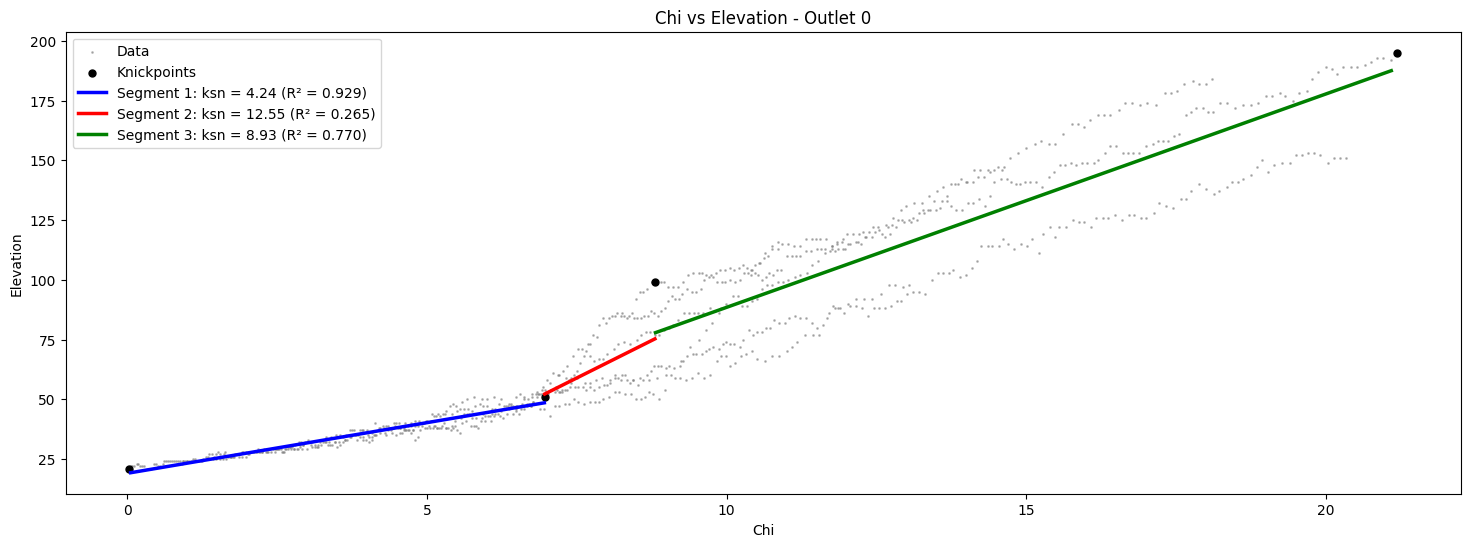

Outlet 0: ksn values = ['4.24', '12.55', '8.93']


[4.23736959189485, 12.547448575438978, 8.92704741013345]

In [34]:
# Enter knickpoint (chi, elevation) locations both the bottom and top locations:
# RP-S2
analyze_outlet(0, [(0.026572082, 21), (6.96, 51), (8.81, 99), (21.1904427, 195)])

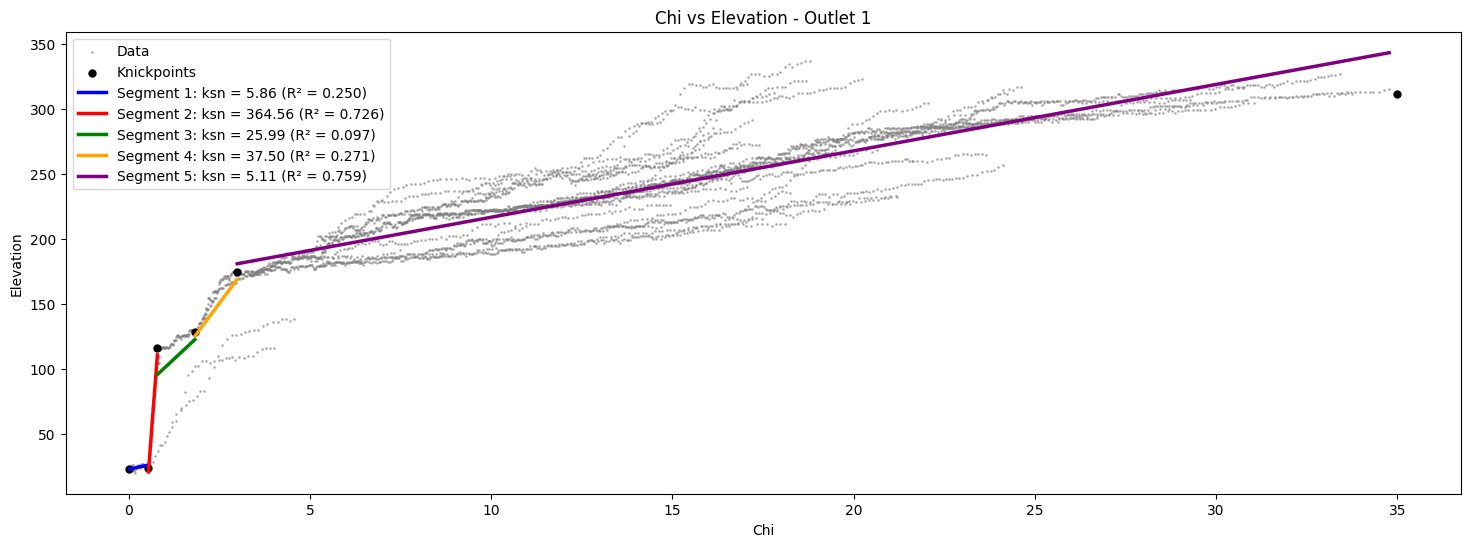

Outlet 1: ksn values = ['5.86', '364.56', '25.99', '37.50', '5.11']


[5.864638619390934,
 364.5647448323169,
 25.98714700138822,
 37.49838582403038,
 5.107038106606756]

In [35]:
# RP-S3
analyze_outlet(1, [(0.012829789, 23), (0.547, 24), (0.796, 116), (1.84, 128), (2.997, 174), (35, 311)])

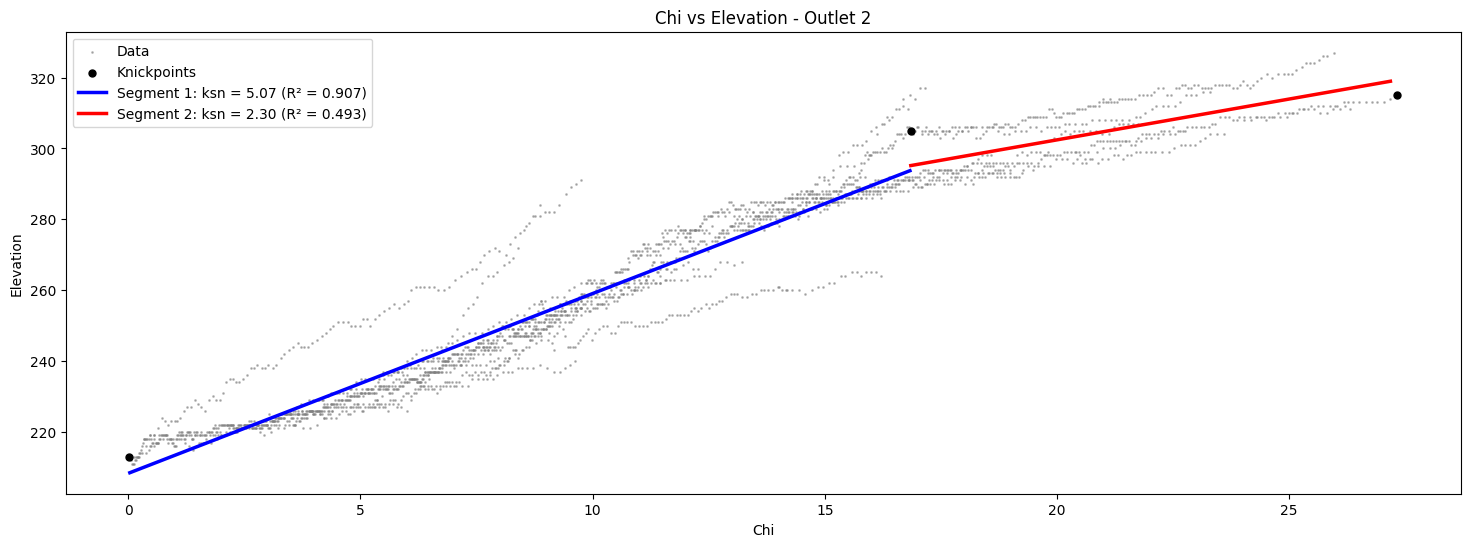

Outlet 2: ksn values = ['5.07', '2.30']


[5.072765847210626, 2.303693760438962]

In [36]:
# RP-S3u
analyze_outlet(2, [(0.016482489, 213), (16.85, 305), (27.32708722,315)])

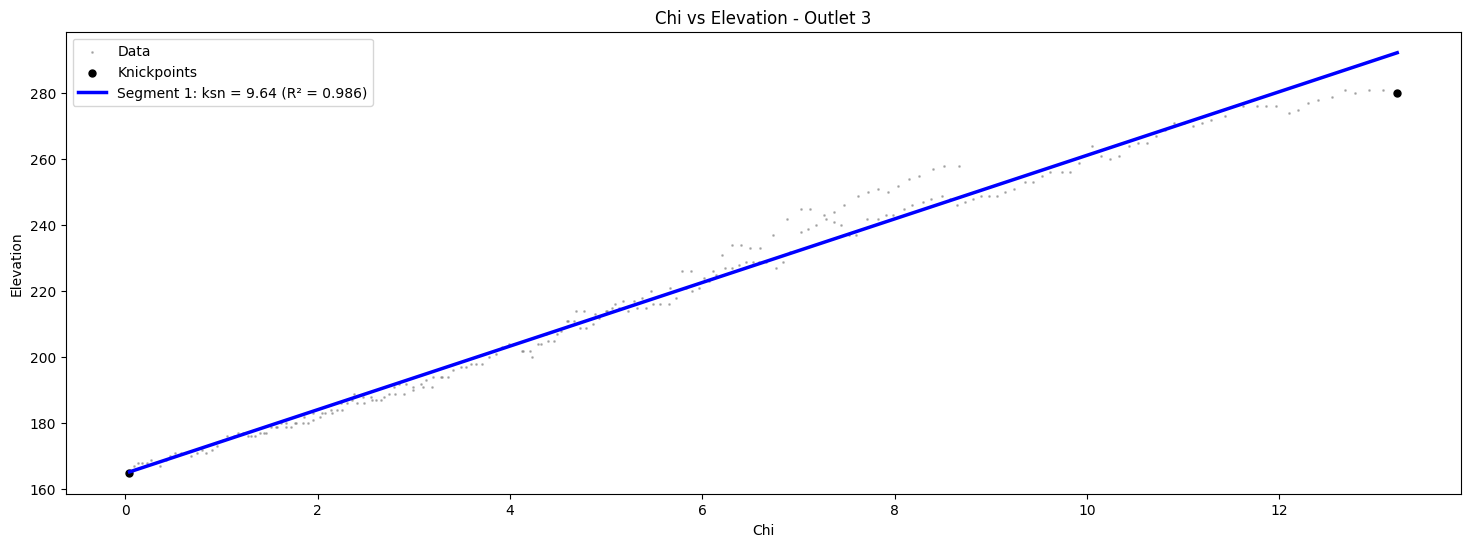

Outlet 3: ksn values = ['9.64']


[9.635589051335689]

In [37]:
# RP-S4u
analyze_outlet(3, [(0.04, 165), (13.23, 280)])

In [38]:
# Getting ksn from slope of smoothed lines. 

def analyze_outlet_smoothed(outlet_index, knickpoints, smooth=True, window=51):
    """
    Calculate and plot ksn for different segments of a single outlet with optional smoothing.
    
    outlet_index: which outlet to analyze (0-4)
    knickpoints: list of (chi, elevation) tuples marking segment boundaries
    smooth: whether to smooth the data (default True)
    window: smoothing window size (must be odd number, default 51)
    """
    outlet = outlets[outlet_index]
    
    # Calculate chi and elevation data
    chi_single = d.Chi(flow_direction = fd, area = area, theta = 0.4, Ao = 1, outlets = [outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask = area_data >= 1e6
    
    chi_filtered = chi_data[mask]
    elev_filtered = elev_data[mask]
    
    # Sort by chi
    sort_idx = np.argsort(chi_filtered)
    chi_sorted = chi_filtered[sort_idx]
    elev_sorted = elev_filtered[sort_idx]
    
    # Apply smoothing if requested
    if smooth:
        window = min(window, len(elev_sorted) // 2 * 2 + 1)  # Ensure window isn't larger than data
        smoothed_elev = savgol_filter(elev_sorted, window, 3)
    else:
        smoothed_elev = elev_sorted
    
    # Plot all data
    plt.figure(figsize=(18, 6))
    plt.scatter(chi_sorted, elev_sorted, s=1, alpha=0.3, color='lightgray', label='Raw data')
    
    if smooth:
        plt.plot(chi_sorted, smoothed_elev, 'gray', linewidth=1.5, alpha=0.7, label='Smoothed')
    
    # Plot knickpoints
    knickpoint_chis = [k[0] for k in knickpoints]
    knickpoint_elevs = [k[1] for k in knickpoints]
    plt.scatter(knickpoint_chis, knickpoint_elevs, color='black', s=20, marker='.', linewidth=3, label='Knickpoints')
    
    ksn_list = []
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    # Create segments from knickpoints
    for seg_idx in range(len(knickpoints) - 1):
        chi_min = knickpoints[seg_idx][0]
        chi_max = knickpoints[seg_idx + 1][0]
        
        segment_mask = (chi_sorted >= chi_min) & (chi_sorted <= chi_max)
        chi_seg = chi_sorted[segment_mask]
        elev_seg = smoothed_elev[segment_mask] if smooth else elev_sorted[segment_mask]
        
        if len(chi_seg) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(chi_seg, elev_seg)
            ksn_list.append(slope)
            
            # Plot the fitted line for this segment
            x_line = np.array([chi_seg.min(), chi_seg.max()])
            y_line = slope * x_line + intercept
            plt.plot(x_line, y_line, linewidth=1, color=colors[seg_idx], 
                    label=f'Segment {seg_idx+1}: ksn = {slope:.2f} (R² = {r_value**2:.3f})')
    
    plt.xlabel('Chi')
    plt.ylabel('Elevation')
    title = f'Chi vs Elevation - Outlet {outlet_index}'
    if smooth:
        title += ' (Smoothed)'
    plt.title(title)
    plt.legend()
    plt.show()
    
    print(f"Outlet {outlet_index}: ksn values = {[f'{k:.2f}' for k in ksn_list]}")
    return ksn_list

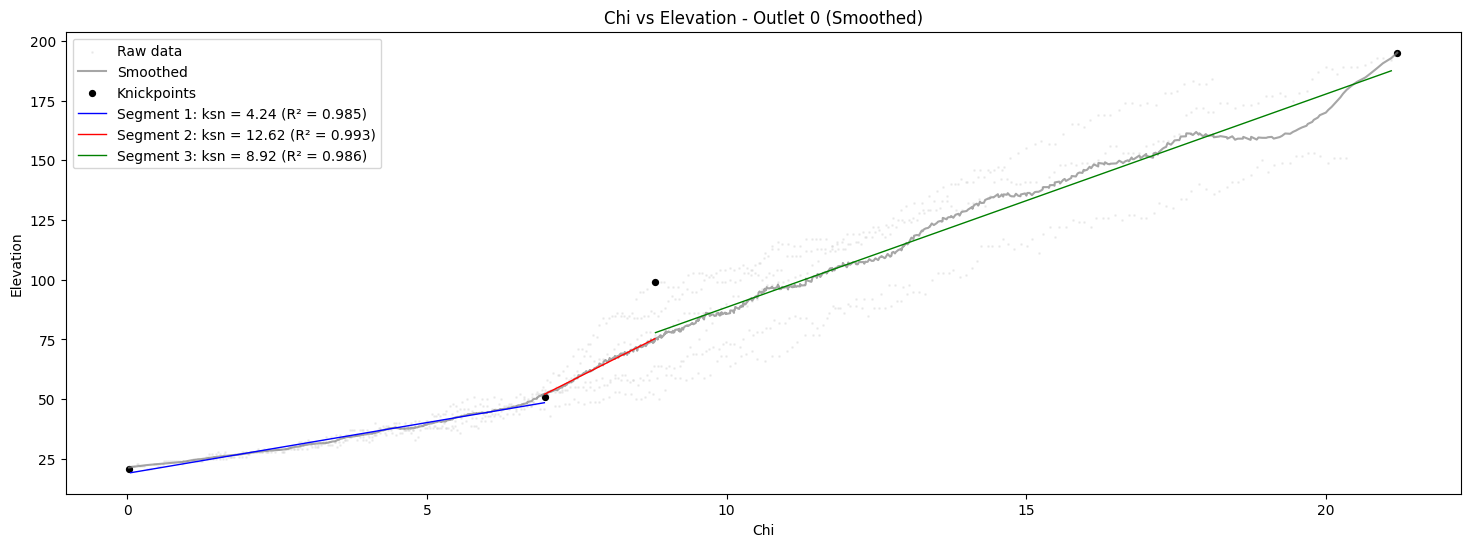

Outlet 0: ksn values = ['4.24', '12.62', '8.92']


[4.2434931725283205, 12.615938281342771, 8.923878881201093]

In [39]:
# RP-S2
analyze_outlet_smoothed(0, [(0.026572082, 21), (6.96, 51), (8.81, 99), (21.1904427, 195)], smooth=True, window=51)

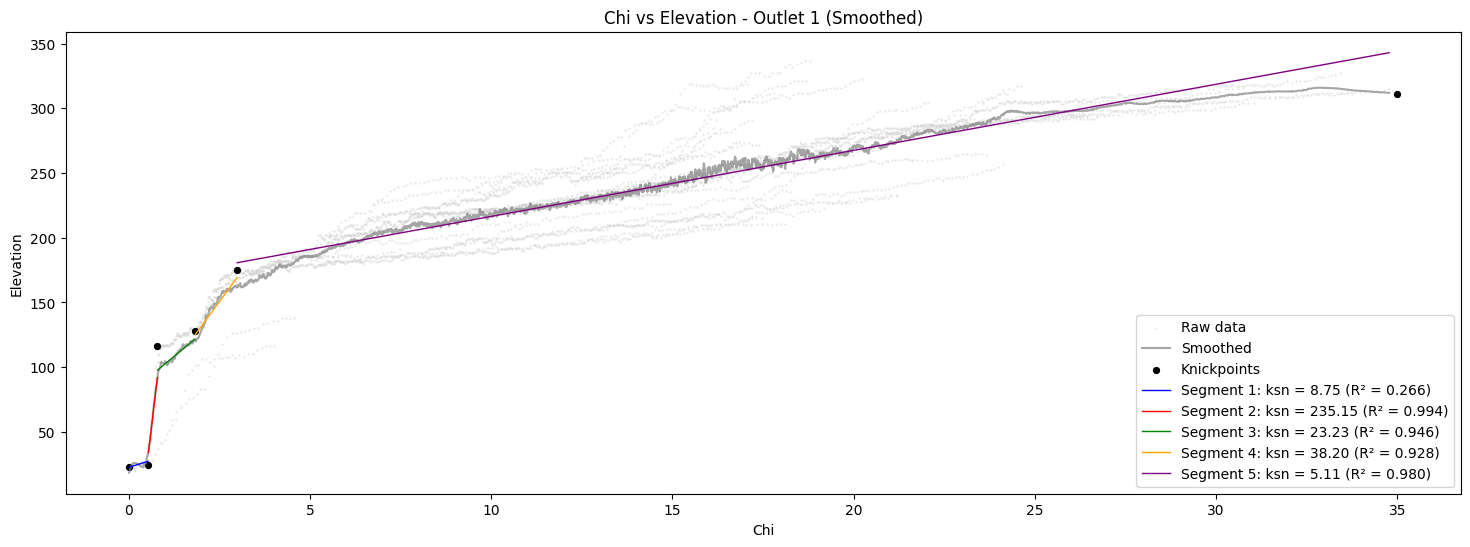

Outlet 1: ksn values = ['8.75', '235.15', '23.23', '38.20', '5.11']


[8.75072323881374,
 235.15211349704117,
 23.228909177420547,
 38.200613579243004,
 5.108126417976834]

In [40]:
# Rapel River outlets - modify knickpoints and run individual analyses
# RP-S3
analyze_outlet_smoothed(1, [(0.012829789, 23), (0.547, 24), (0.796, 116), (1.84, 128), (2.997, 175), (35, 311)], smooth=True, window=51)

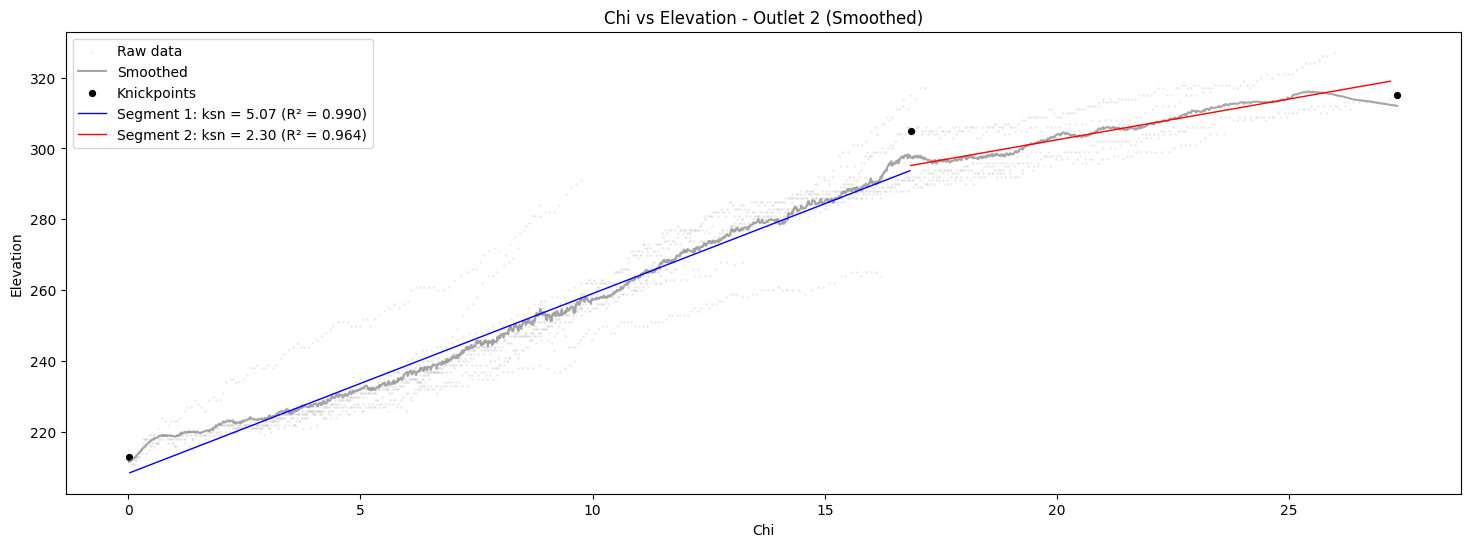

Outlet 2: ksn values = ['5.07', '2.30']


[5.0715740229507835, 2.3028767507250274]

In [41]:
# RP-S3u
analyze_outlet_smoothed(2, [(0.016482489, 213), (16.85, 305), (27.32708722,315)], smooth=True, window=51)

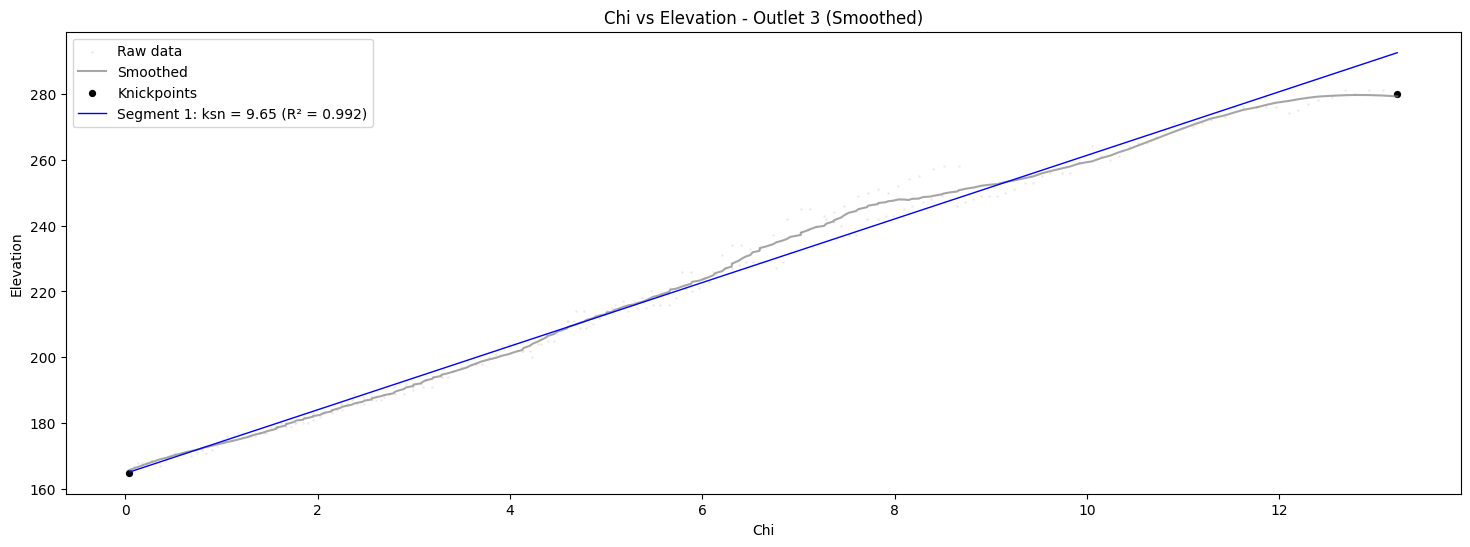

Outlet 3: ksn values = ['9.65']


[9.648144540379505]

In [42]:
# RP-S4u
analyze_outlet_smoothed(3, [(0.04, 165), (13.23, 280)], smooth=True, window=51)

In [63]:
# Read shapefiles
shp1 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S2_mask/RP_S2_mask.shp')
shp2 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3_mask/RP_S3_mask.shp')
shp3 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3u_mask/RP_S3u_mask.shp')
shp4 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S4u_mask/RP_S4u_mask.shp')

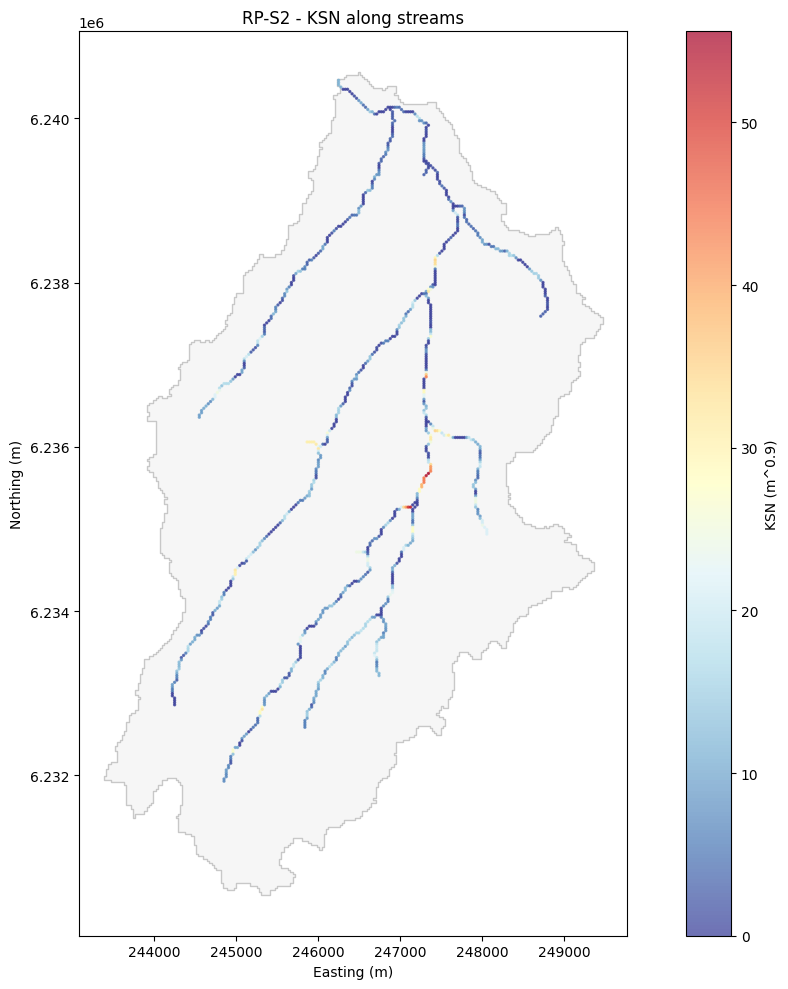

Plotted RP-S2 with 980 stream points


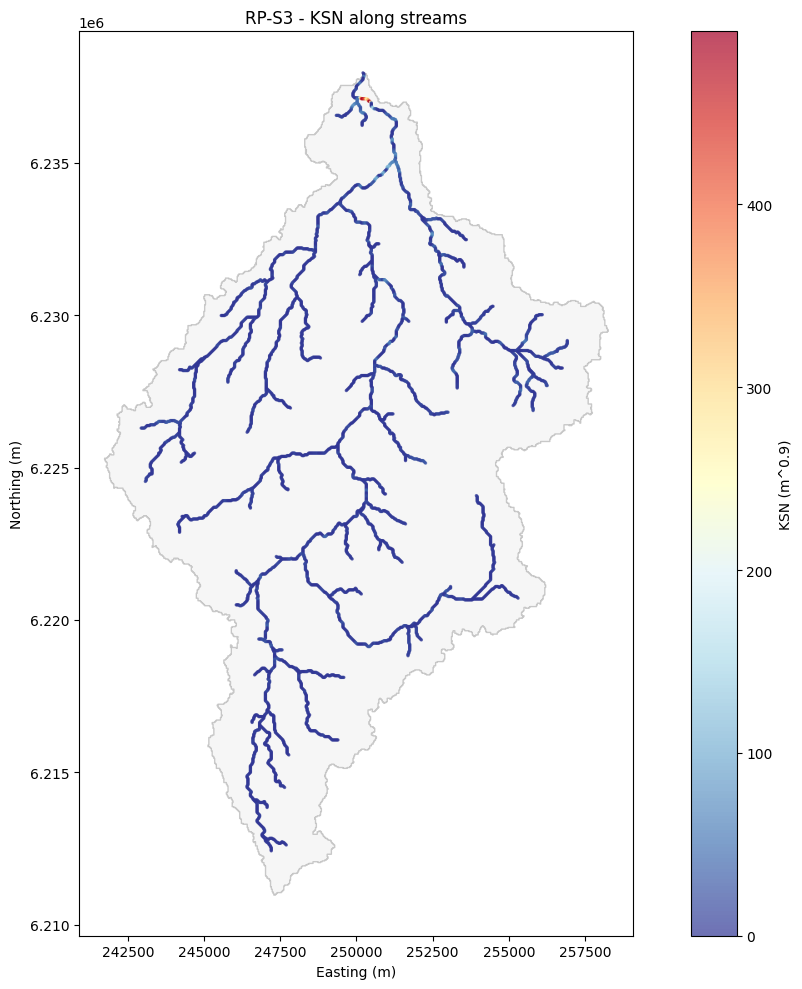

Plotted RP-S3 with 4986 stream points


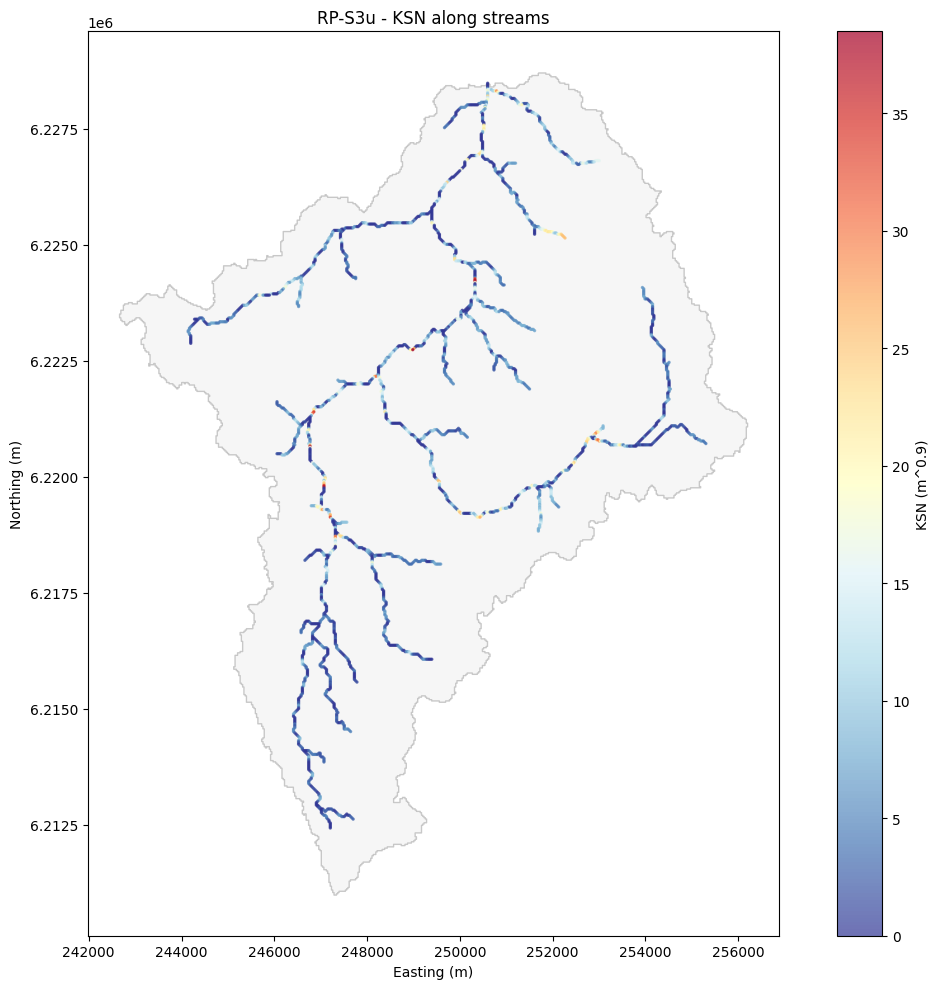

Plotted RP-S3u with 2521 stream points


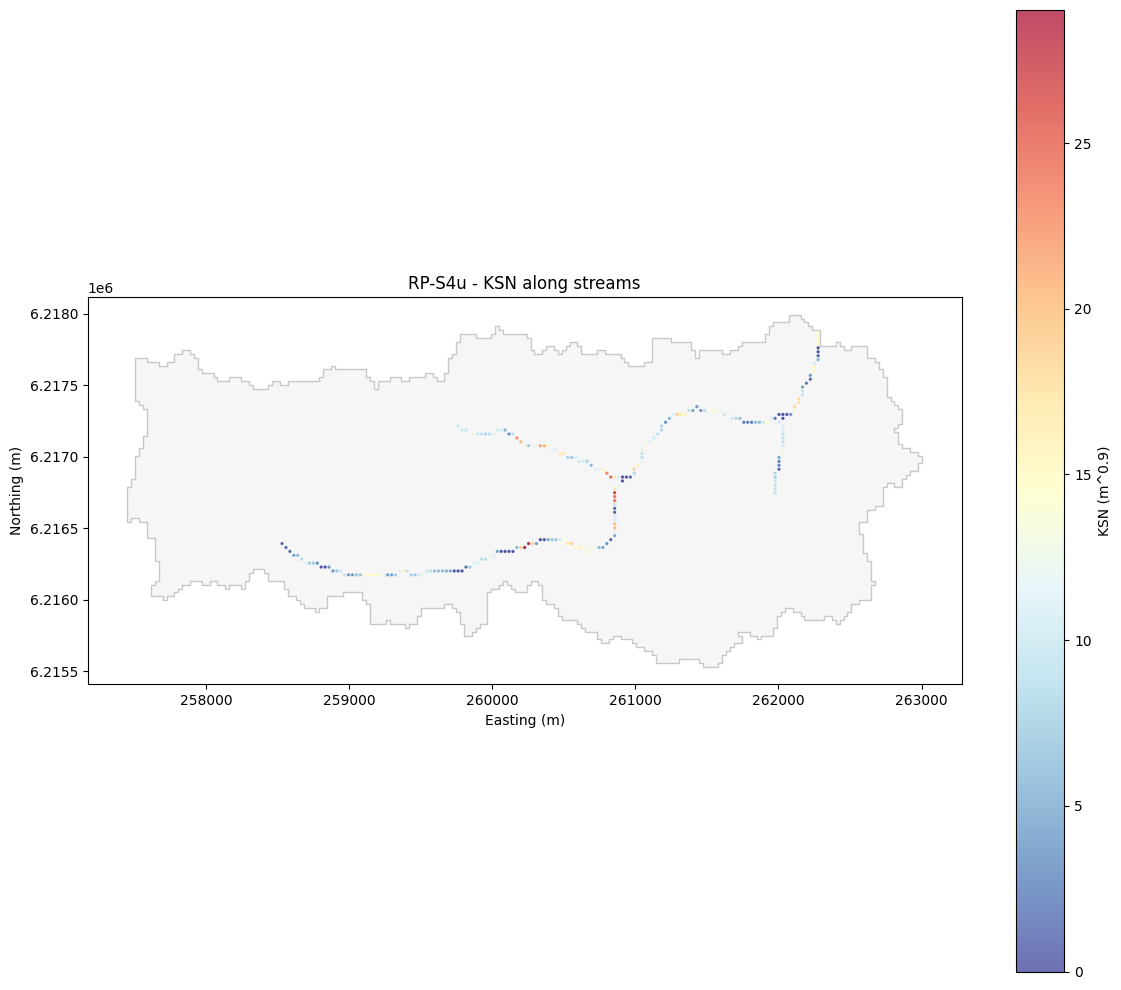

Plotted RP-S4u with 233 stream points


In [65]:
# Plotting chi for each polygon

# Define chi ranges and ksn values for each outlet
outlet_segments = {
    0: {  # RP-S2
        'chi_ranges': [(0, 0.026572082), (0.026572082, 6.96), (6.96, 8.81), (8.81, 21.1904427)],
        'ksn_values': [4.24, 12.62, 8.92, 1.0],
        'shp': shp1,
        'name': 'RP-S2'
    },
    1: {  # RP-S3
        'chi_ranges': [(0, 0.012829789), (0.012829789, 0.547), (0.547, 0.796), (0.796, 1.84), (1.84, 2.997), (2.997, 35)],
        'ksn_values': [8.75, 235.15, 23.23, 38.20, 5.11, 1.0],
        'shp': shp2,
        'name': 'RP-S3'
    },
    2: {  # RP-S3u
        'chi_ranges': [(0, 0.016482489), (0.016482489, 16.85), (16.85, 27.32708722)],
        'ksn_values': [5.07, 2.30, 1.0],
        'shp': shp3,
        'name': 'RP-S3u'
    },
    3: {  # RP-S4u
        'chi_ranges': [(0, 0.04), (0.04, 13.23)],
        'ksn_values': [9.65, 1.0],
        'shp': shp4,
        'name': 'RP-S4u'
    }
}

def assign_ksn_to_chi(chi_value, outlet_idx):
    """Assign ksn value based on chi value"""
    segments = outlet_segments[outlet_idx]
    for chi_range, ksn in zip(segments['chi_ranges'], segments['ksn_values']):
        if chi_range[0] <= chi_value < chi_range[1]:
            return ksn
    return segments['ksn_values'][-1]

def plot_outlet_streams(outlet_idx):
    """Plot streams colored by ksn within polygon"""
    outlet = outlets[outlet_idx]
    segments = outlet_segments[outlet_idx]
    
    # Calculate chi for this outlet
    chi_single = d.Chi(flow_direction=fd, area=area, theta=0.4, Ao=1, outlets=[outlet])
    
    chi_grid = chi_single._griddata
    area_grid = area._griddata
    
    # Create mask for valid streams (chi > 0 and area >= 1 km^2)
    mask = (chi_grid > 0) & (area_grid >= 1e6)
    
    # Get coordinates from raster indices
    rows, cols = np.where(mask)
    
    # Extract chi and elevation values for valid points
    chi_filtered = chi_grid[rows, cols]
    elev_grid = elevation._griddata
    elev_filtered = elev_grid[rows, cols]
    
    # Convert row/col indices to geographic coordinates
    # Pass all pairs at once as a list of tuples
    row_col_pairs = list(zip(rows, cols))
    coords = np.array(area._rowscols_to_xy(row_col_pairs))
    x_coords = coords[:, 0]
    y_coords = coords[:, 1]
    
    # Calculate local ksn using elevation and chi gradients
    local_ksn = np.zeros(len(rows))
    window_size = 5  # Look at nearby stream pixels
    
    # Create a spatial index for quick neighbor lookup
    from scipy.spatial import cKDTree
    coords_tree = cKDTree(np.column_stack([x_coords, y_coords]))
    
    for idx, (r, c) in enumerate(row_col_pairs):
        # Find nearby stream points
        distances, indices = coords_tree.query([x_coords[idx], y_coords[idx]], k=min(window_size + 1, len(x_coords)))
        
        # Get chi and elevation values for nearby points
        nearby_chi = chi_filtered[indices]
        nearby_elev = elev_filtered[indices]
        
        if len(nearby_chi) > 2:
            # Calculate ksn as slope of elevation vs chi
            # Use linear regression on nearby points
            from scipy.stats import linregress
            slope, intercept, r_value, p_value, std_err = linregress(nearby_chi, nearby_elev)
            local_ksn[idx] = slope if slope > 0 else 0
        else:
            local_ksn[idx] = 0
    
    # Cap extreme values for better visualization
    local_ksn[local_ksn > 500] = 500  # Remove outliers
    ksn_assigned = local_ksn
    
    # Create figure and plot polygon
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot watershed polygon
    segments['shp'].plot(ax=ax, alpha=0.2, edgecolor='black', facecolor='lightgray')
    
    # Plot stream points colored by ksn
    scatter = ax.scatter(x_coords, y_coords, c=ksn_assigned, s=2, cmap='RdYlBu_r', alpha=0.7)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, label='KSN (m^0.9)')
    
    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')
    ax.set_title(f'{segments["name"]} - KSN along streams')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Plotted {segments['name']} with {len(ksn_assigned)} stream points")

#PLOT INDIVIDUAL OUTLETS
plot_outlet_streams(0)  # RP-S2
plot_outlet_streams(1)  # RP-S3
plot_outlet_streams(2)  # RP-S3u
plot_outlet_streams(3)  # RP-S4u